In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,classification_report,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as utils
from torch.optim import Adam 

In [2]:
trainloader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device('cpu')

cuda


In [4]:
def call_pr_loss(a , variance):
    k = len(a[0])
    l = torch.sum(a**2)/ variance**2 /2/k
    return k/2*math.log(2*math.pi) + 0.5*k*math.log(variance) + l

In [24]:
def get_model():
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(784, 200))
    model.add_module('r1', nn.Sigmoid())
    model.add_module('l2', nn.Linear(200, 200))
    model.add_module('r2', nn.Sigmoid())
    model.add_module('l3', nn.Linear(200, 200))
    model.add_module('r3', nn.Sigmoid())

    model.add_module('lf', nn.Linear(200, 10))

    model.to(device)
    return model

In [14]:
def eva(test_loader , model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return (test_loss ,correct / len(test_loader.dataset) )

In [17]:
m_200 = 1
m_784 = 1

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 7):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784)
        loss_2 = call_pr_loss(model.l2.weight , m_200)
        loss_3 = call_pr_loss(model.l3.weight , m_200)
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200)
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    scheduler.step()

Train Epoch: 1 [15984/60000 (27%)]	Loss: 1273.077637 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 1272.683472 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 1272.713135 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 1272.667969 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 1272.524658 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 1272.529053 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 1272.564453 
Train Epoch: 3 [7984/60000 (13%)]	Loss: 1272.808716 
Train Epoch: 3 [23984/60000 (40%)]	Loss: 1272.771606 
Train Epoch: 3 [39984/60000 (67%)]	Loss: 1272.528442 
Train Epoch: 3 [55984/60000 (93%)]	Loss: 1272.982666 
Train Epoch: 4 [11984/60000 (20%)]	Loss: 1272.658691 
Train Epoch: 4 [27984/60000 (47%)]	Loss: 1272.611694 
Train Epoch: 4 [43984/60000 (73%)]	Loss: 1272.553955 
Train Epoch: 4 [59984/60000 (100%)]	Loss: 1272.542480 
Train Epoch: 5 [15984/60000 (27%)]	Loss: 1272.583862 
Train Epoch: 5 [31984/60000 (53%)]	Loss: 1272.491699 
Train Epoch: 5 [47984/60000 (80%)]	Loss: 1272.529297 
Train Epoch: 6 [3984/60000 (7%

In [20]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0220, Accuracy: 9161/10000 (92%)



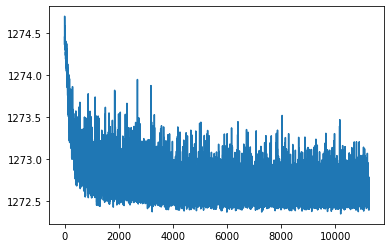

In [13]:
plt.plot(loss_history)

# проверка гипотез

## 1. увеличиваем дисперсию с номером слоя

для этого введем на который будем умножать дисперсию слоя

In [21]:
weight = [1,2,3,4,5]

In [25]:
model = get_model()

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 7):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784*weight[0])
        loss_2 = call_pr_loss(model.l2.weight , m_200*weight[1])
        loss_3 = call_pr_loss(model.l3.weight , m_200*weight[2])
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200*weight[3])
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

Train Epoch: 1 [15984/60000 (27%)]	Loss: 1590.065430 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 1590.333984 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 1589.946411 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 1590.177856 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 1590.312012 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 1590.057007 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 1589.971436 
Train Epoch: 3 [7984/60000 (13%)]	Loss: 1590.025391 
Train Epoch: 3 [23984/60000 (40%)]	Loss: 1589.879883 
Train Epoch: 3 [39984/60000 (67%)]	Loss: 1590.156616 
Train Epoch: 3 [55984/60000 (93%)]	Loss: 1589.914673 
Train Epoch: 4 [11984/60000 (20%)]	Loss: 1590.164429 
Train Epoch: 4 [27984/60000 (47%)]	Loss: 1589.908325 
Train Epoch: 4 [43984/60000 (73%)]	Loss: 1589.944092 
Train Epoch: 4 [59984/60000 (100%)]	Loss: 1589.983154 
Train Epoch: 5 [15984/60000 (27%)]	Loss: 1589.859131 
Train Epoch: 5 [31984/60000 (53%)]	Loss: 1590.236694 
Train Epoch: 5 [47984/60000 (80%)]	Loss: 1589.918213 
Train Epoch: 6 [3984/60000 (7%

In [28]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0088, Accuracy: 9564/10000 (96%)



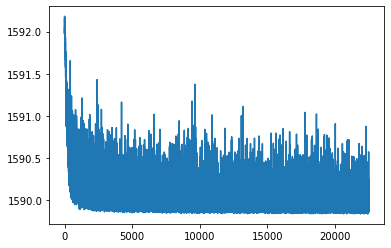

In [29]:
plt.plot(loss_history)

## уменьшение дисперсии от большой к малой (линейное)

In [35]:
weight = [5,4,3,2,1]
model = get_model()


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 7):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784*weight[0])
        loss_2 = call_pr_loss(model.l2.weight , m_200*weight[1])
        loss_3 = call_pr_loss(model.l3.weight , m_200*weight[2])
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200*weight[3])
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

Train Epoch: 1 [15984/60000 (27%)]	Loss: 2220.861816 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 2220.879639 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 2220.714844 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 2220.708496 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 2220.852295 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 2220.690918 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 2220.866455 
Train Epoch: 3 [7984/60000 (13%)]	Loss: 2220.907715 
Train Epoch: 3 [23984/60000 (40%)]	Loss: 2220.683350 
Train Epoch: 3 [39984/60000 (67%)]	Loss: 2220.945557 
Train Epoch: 3 [55984/60000 (93%)]	Loss: 2220.720947 
Train Epoch: 4 [11984/60000 (20%)]	Loss: 2220.713867 
Train Epoch: 4 [27984/60000 (47%)]	Loss: 2220.739990 
Train Epoch: 4 [43984/60000 (73%)]	Loss: 2220.800537 
Train Epoch: 4 [59984/60000 (100%)]	Loss: 2220.780029 
Train Epoch: 5 [15984/60000 (27%)]	Loss: 2220.749268 
Train Epoch: 5 [31984/60000 (53%)]	Loss: 2220.703613 
Train Epoch: 5 [47984/60000 (80%)]	Loss: 2220.674805 
Train Epoch: 6 [3984/60000 (7%

In [37]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0066, Accuracy: 9688/10000 (97%)



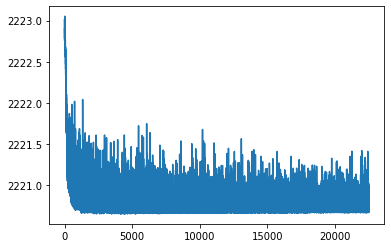

In [38]:
plt.plot(loss_history)

## уменьшение дисперсии от большой к малой (экспоненциальное)

In [39]:
weight = [16,8,4,2,1]
model = get_model()

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 7):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784*weight[0])
        loss_2 = call_pr_loss(model.l2.weight , m_200*weight[1])
        loss_3 = call_pr_loss(model.l3.weight , m_200*weight[2])
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200*weight[3])
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

Train Epoch: 1 [15984/60000 (27%)]	Loss: 2774.781982 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 2774.658936 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 2774.721191 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 2774.899414 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 2775.143311 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 2774.683838 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 2774.675049 
Train Epoch: 3 [7984/60000 (13%)]	Loss: 2774.729736 
Train Epoch: 3 [23984/60000 (40%)]	Loss: 2774.647461 
Train Epoch: 3 [39984/60000 (67%)]	Loss: 2774.647949 
Train Epoch: 3 [55984/60000 (93%)]	Loss: 2774.646240 
Train Epoch: 4 [11984/60000 (20%)]	Loss: 2774.696289 
Train Epoch: 4 [27984/60000 (47%)]	Loss: 2774.674805 
Train Epoch: 4 [43984/60000 (73%)]	Loss: 2774.787109 
Train Epoch: 4 [59984/60000 (100%)]	Loss: 2774.662109 
Train Epoch: 5 [15984/60000 (27%)]	Loss: 2774.655762 
Train Epoch: 5 [31984/60000 (53%)]	Loss: 2774.836426 
Train Epoch: 5 [47984/60000 (80%)]	Loss: 2774.733887 
Train Epoch: 6 [3984/60000 (7%

In [41]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0061, Accuracy: 9706/10000 (97%)



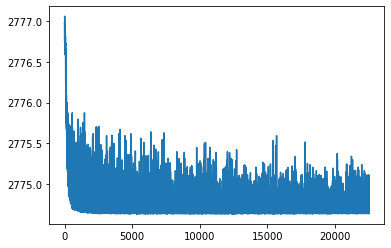

In [42]:
plt.plot(loss_history)

видим что значения дисперсий слишком большие для этой модели 

## without prior

In [43]:
model = get_model()

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 7):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        #loss_1 = call_pr_loss(model.l1.weight , m_784*weight[0])
        #loss_2 = call_pr_loss(model.l2.weight , m_200*weight[1])
        #loss_3 = call_pr_loss(model.l3.weight , m_200*weight[2])
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        #loss_f = call_pr_loss(model.lf.weight , m_200*weight[3])
        
        
        loss = loss_0 #+ loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

Train Epoch: 1 [15984/60000 (27%)]	Loss: 0.481881 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 0.152889 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 0.172863 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 0.425005 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 0.008543 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 0.126606 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 0.027704 
Train Epoch: 3 [7984/60000 (13%)]	Loss: 0.002404 
Train Epoch: 3 [23984/60000 (40%)]	Loss: 0.002706 
Train Epoch: 3 [39984/60000 (67%)]	Loss: 0.293016 
Train Epoch: 3 [55984/60000 (93%)]	Loss: 0.007404 
Train Epoch: 4 [11984/60000 (20%)]	Loss: 0.071859 
Train Epoch: 4 [27984/60000 (47%)]	Loss: 0.230536 
Train Epoch: 4 [43984/60000 (73%)]	Loss: 0.003542 
Train Epoch: 4 [59984/60000 (100%)]	Loss: 0.007056 
Train Epoch: 5 [15984/60000 (27%)]	Loss: 0.000631 
Train Epoch: 5 [31984/60000 (53%)]	Loss: 0.037436 
Train Epoch: 5 [47984/60000 (80%)]	Loss: 0.025768 
Train Epoch: 6 [3984/60000 (7%)]	Loss: 0.292954 
Train Epoch: 6 [19984/60000 (33%)]	

In [45]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0058, Accuracy: 9744/10000 (97%)



нужно уменьшить дисперсию для того чтобы разница была более явная


In [46]:
weight = [1,4/5,3/5,2/5,1/5]
model = get_model()

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 7):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784*weight[0])
        loss_2 = call_pr_loss(model.l2.weight , m_200*weight[1])
        loss_3 = call_pr_loss(model.l3.weight , m_200*weight[2])
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200*weight[3])
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

Train Epoch: 1 [15984/60000 (27%)]	Loss: 1108.557617 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 1108.452881 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 1108.558228 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 1108.469604 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 1108.351074 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 1108.154419 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 1108.403809 
Train Epoch: 3 [7984/60000 (13%)]	Loss: 1108.217407 
Train Epoch: 3 [23984/60000 (40%)]	Loss: 1108.872803 
Train Epoch: 3 [39984/60000 (67%)]	Loss: 1108.042236 
Train Epoch: 3 [55984/60000 (93%)]	Loss: 1108.133179 
Train Epoch: 4 [11984/60000 (20%)]	Loss: 1108.174683 
Train Epoch: 4 [27984/60000 (47%)]	Loss: 1108.126953 
Train Epoch: 4 [43984/60000 (73%)]	Loss: 1108.376953 
Train Epoch: 4 [59984/60000 (100%)]	Loss: 1108.320557 
Train Epoch: 5 [15984/60000 (27%)]	Loss: 1108.564453 
Train Epoch: 5 [31984/60000 (53%)]	Loss: 1108.277344 
Train Epoch: 5 [47984/60000 (80%)]	Loss: 1108.158691 
Train Epoch: 6 [3984/60000 (7%

In [48]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0607, Accuracy: 7338/10000 (73%)



In [49]:
weight = [1,8/16,4/16,2/16,1/16]
model = get_model()

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 7):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784*weight[0])
        loss_2 = call_pr_loss(model.l2.weight , m_200*weight[1])
        loss_3 = call_pr_loss(model.l3.weight , m_200*weight[2])
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200*weight[3])
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

Train Epoch: 1 [15984/60000 (27%)]	Loss: 858.147339 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 858.197937 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 858.192078 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 858.266174 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 858.241333 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 858.207336 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 858.226807 
Train Epoch: 3 [7984/60000 (13%)]	Loss: 858.270142 
Train Epoch: 3 [23984/60000 (40%)]	Loss: 858.214905 
Train Epoch: 3 [39984/60000 (67%)]	Loss: 858.229126 
Train Epoch: 3 [55984/60000 (93%)]	Loss: 858.233826 
Train Epoch: 4 [11984/60000 (20%)]	Loss: 858.210449 
Train Epoch: 4 [27984/60000 (47%)]	Loss: 858.243469 
Train Epoch: 4 [43984/60000 (73%)]	Loss: 858.209351 
Train Epoch: 4 [59984/60000 (100%)]	Loss: 858.213867 
Train Epoch: 5 [15984/60000 (27%)]	Loss: 858.253052 
Train Epoch: 5 [31984/60000 (53%)]	Loss: 858.254028 
Train Epoch: 5 [47984/60000 (80%)]	Loss: 858.228149 
Train Epoch: 6 [3984/60000 (7%)]	Loss: 858.24121

In [51]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

